In [645]:
import pandas as pd

In [646]:
# Get the data

def getData():

	import requests

	files = [
	"time_series_19-covid-Confirmed.csv",
	"time_series_19-covid-Deaths.csv",
	"time_series_19-covid-Recovered.csv"
	]

	headers = {'Accept': 'application/vnd.github.v3.raw'}

	for path in files:
		url = "https://api.github.com/repos/CSSEGISandData/COVID-19/contents/csse_covid_19_data/csse_covid_19_time_series/{path}".format(path=path)
		print("Getting", path)
		r = requests.get(url, headers=headers)
		with open(path, 'w') as f:
			f.write(r.text)
			
	print("Files saved")

getData()

Getting time_series_19-covid-Confirmed.csv
Getting time_series_19-covid-Deaths.csv
Getting time_series_19-covid-Recovered.csv
Files saved


In [647]:
# Read in the data and have a look
confirmed = pd.read_csv("time_series_19-covid-Confirmed.csv")
confirmed[confirmed['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,26,28,38,48,55,65,65,92,112,134
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,10,11,11,15,18,21,21,36,49,57
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,13,13,15,15,18,20,20,35,46,61
19,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,7,7,7,7,7,9,9,16,19,20
22,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,3,3,3,4,6,9,9,14,17,17
62,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,1,1,2,2,2,3,3,5,5,6
72,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
404,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [648]:
# Clear out regions and lat/lon / general data cleanup
colnames = list(confirmed.columns.values)
dates = colnames[4:]
melted_confirmed = confirmed.melt(id_vars='Country/Region', var_name='Date', value_name='ConfirmedCases')
melted_confirmed = melted_confirmed.groupby(['Date','Country/Region'])['ConfirmedCases'].sum().reset_index()
melted_confirmed = melted_confirmed = melted_confirmed[melted_confirmed['Date'].isin(dates)]
melted_confirmed = melted_confirmed.sort_values(by=['ConfirmedCases'])
melted_confirmed['Date'] = pd.to_datetime(melted_confirmed['Date'], infer_datetime_format=True)  
melted_confirmed['ConfirmedCases'] = melted_confirmed['ConfirmedCases'].astype(int)
melted_confirmed.head()

,Date,Country/Region,ConfirmedCases
0,2020-01-22,Afghanistan,0
4104,2020-02-25,Trinidad and Tobago,0
4103,2020-02-25,Togo,0
4098,2020-02-25,Suriname,0
4097,2020-02-25,Sudan,0


In [649]:
# Read in population data, and only include countries with >100 cases
country_pop = pd.read_csv('Dev/country_population.csv')
melted_confirmed_wpop = pd.merge(melted_confirmed, country_pop, on = 'Country/Region', how = 'left').fillna(0)
melted_confirmed_wpop.rename(columns = {'Country/Region':'Country'}, inplace = True) 
melted_confirmed_wpop['Population'] = melted_confirmed_wpop['Population'].astype(int)
melted_confirmed_wpop['population_proportion'] = (melted_confirmed_wpop['ConfirmedCases'] / melted_confirmed_wpop['Population'])*100
melted_confirmed_wpop = melted_confirmed_wpop[melted_confirmed_wpop['ConfirmedCases'] > 100]
melted_confirmed_wpop['day_since_100'] = melted_confirmed_wpop.groupby('Country').cumcount() + 1
melted_confirmed_wpop['dod_growth'] = melted_confirmed_wpop['population_proportion'].pct_change()
melted_confirmed_wpop = melted_confirmed_wpop[melted_confirmed_wpop['Country'] != 'Cruise Ship']

In [650]:
# Look at the first week
first_week = days_since_dataframe[days_since_dataframe['day_since_100'] < 20] #change this to adjust timeframe
first_week = pd.DataFrame(first_week.pivot(index='Country', columns='day_since_100', values=['ConfirmedCases']).fillna("").reset_index())
first_week

Country ConfirmedCases                              \
day_since_100                              1    2    3     4     5     6   
0                   Australia          107.0  128  128   200   250         
1                     Austria          104.0  131  182   246   302   504   
2                     Bahrain          110.0  189  195   195   210         
3                     Belgium          109.0  169  200   239   267   314   
4                      Brazil          151.0  151                          
5                      Canada          108.0  117  193   198               
6                       China          548.0  643  920  1406  2075  2877   
7                     Czechia          141.0  189                          
8                     Denmark          264.0  444  617   804   836         
9                       Egypt          109.0                               
10                    Estonia          115.0                               
11                    Finland          155.0  225                          
12                     France          130.0  191  204   288   380   656   
13                    Germany          130.0  159  196   262   482   670   
14                     Greece          190.0  228                          
15                    Iceland          103.0  134  156                     
16                      India          102.0                               
17                       Iran          139.0  245  388   593   978  1501   
18                       Iraq          101.0  110                          
19                    Ireland          129.0                               
20                     Israel          109.0  131  161   193               
21                      Italy          155.0  229  322   453   655   888   
22                      Japan          105.0  122  147   159   170   189   
23               Korea, South          104.0  204  433   602   833   977   
24                     Kuwait          104.0                               
25                   Malaysia          117.0  129  149   149   197   238   
26                Netherlands          128.0  188  265   321   382   503   
27                     Norway          108.0  147  176   205   400   598   
28                Philippines          111.0                               
29                     Poland          103.0                               
30                   Portugal          112.0  169                          
31                      Qatar          262.0  262  320   337               
32                    Romania          123.0                               
33               Saudi Arabia          103.0                               
34                  Singapore          102.0  106  108   110   110   117   
35                   Slovenia          141.0  181                          
36                      Spain          120.0  165  222   259   400   500   
37                     Sweden          101.0  161  203   248   355   500   
38                Switzerland          114.0  214  268   337   374   491   
39                         US          118.0  149  217   262   402   518   
40             United Kingdom          116.0  164  207   274   322   384   

                                                                          \
day_since_100     7     8     9    10     11     12     13     14     15   
0                                                                          
1               655                                                        
2                                                                          
3               314   559   689                                            
4                                                                          
5                                                                          
6              5509  6087  8141  9802  11891  16630  19716  23707  27440   
7                                                                    

In [651]:
#Look at a few countries
melted_confirmed_wpop = melted_confirmed_wpop[(melted_confirmed_wpop['Country'] == 'Austria') | (melted_confirmed_wpop['Country'] == 'Australia') | (melted_confirmed_wpop['Country'] == 'Belgium') | (melted_confirmed_wpop['Country'] == 'Japan')]
melted_confirmed_wpop.groupby(['Continent','Country']).count() 

Date  ConfirmedCases  Population  population_proportion  \
Continent Country                                                              
Asia      Japan        24              24          24                     24   
Europe    Austria       8               8           8                      8   
          Belgium      10              10          10                     10   
Oceania   Australia     6               6           6                      6   

                     day_since_100  dod_growth  
Continent Country                               
Asia      Japan                 24          24  
Europe    Austria                8           8  
          Belgium               10          10  
Oceania   Australia              6           6

In [653]:
#Plot it

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
fig = px.line(melted_confirmed_wpop[melted_confirmed_wpop['day_since_100'] > 1], x="day_since_100", y="ConfirmedCases", color='Country', line_group="Country")
fig.show() 

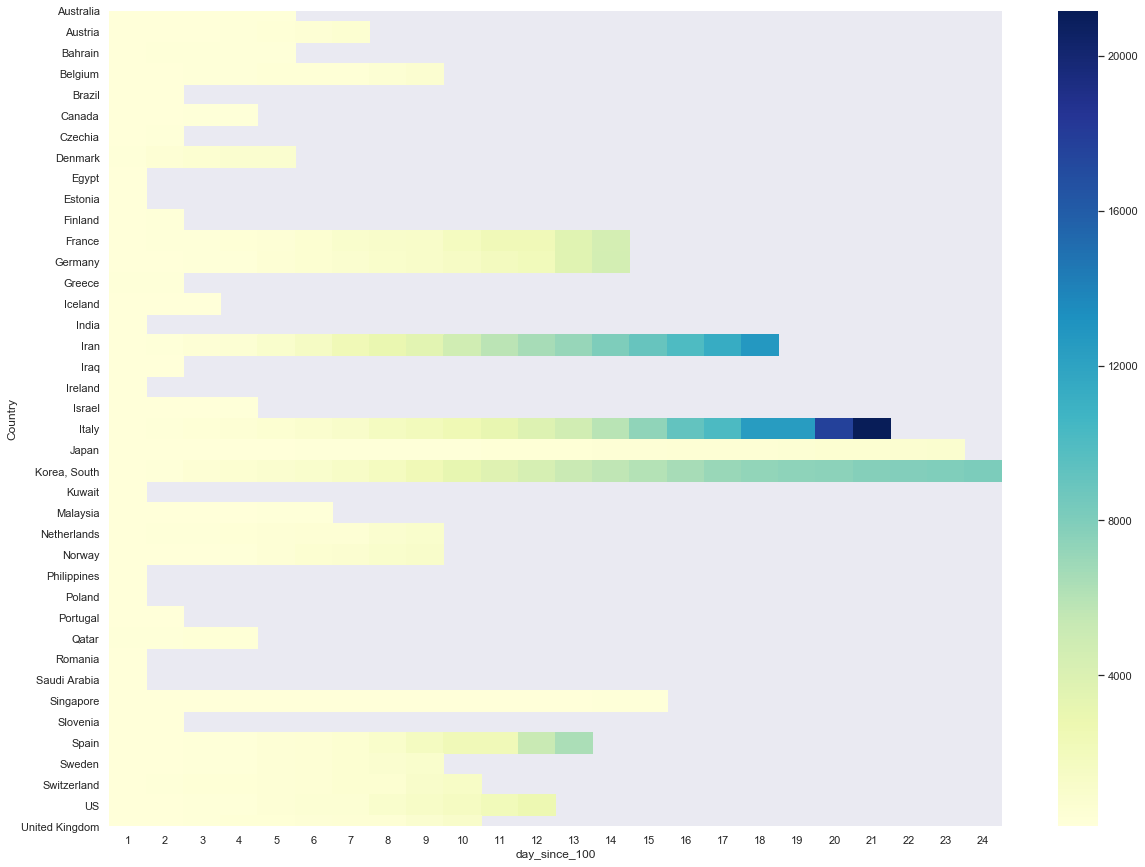

In [671]:
import seaborn as sns
%matplotlib inline

heatmap1_data = days_since_dataframe[days_since_dataframe['Country'] != 'China']
heatmap1_data = pd.pivot_table(heatmap1_data, values='ConfirmedCases', 
                     index=['Country'], 
                     columns='day_since_100')

plt.subplots(figsize=(20,15))
sns.heatmap(heatmap1_data, cmap="YlGnBu")